In [1]:
# load important modules

import numpy
import nltk
import sklearn
!pip install ipdb
import ipdb
!pip install tensorboardX
import tensorboardX
import pytorch as torch

In [2]:
# Clone GitHub repository to enable downloading GLUE data
!git clone https://github.com/nyu-mll/GLUE-baselines
!git clone https://github.com/wasiahmad/paraphrase_identification.git

fatal: destination path 'GLUE-baselines' already exists and is not an empty directory.
fatal: destination path 'paraphrase_identification' already exists and is not an empty directory.


In [7]:
# Download GLUE data
!python GLUE-baselines/download_glue_data.py --data_dir="C:/Users/annko/Documents/Masterthesis/Masterthesis" --tasks all --path_to_mrpc=paraphrase_identification/dataset/msr-paraphrase-corpus

	Completed!
	Completed!
Processing MRPC...
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from collections import defaultdict
import math

In [11]:
# define data direction to read data
data_dir = "C:/Users/annko/Documents/Masterthesis/Masterthesis/"

# read respective GLUE tasks

# WNLI
wnli_train = pd.read_csv("{}/WNLI/train.tsv".format(data_dir), delimiter='\\t')
wnli_dev = pd.read_csv("{}/WNLI/dev.tsv".format(data_dir), delimiter='\\t')

# RTE
rte_train = pd.read_csv("{}/RTE/train.tsv".format(data_dir), delimiter='\\t')
rte_dev = pd.read_csv("{}/RTE/dev.tsv".format(data_dir), delimiter='\\t')

# MRPC
mrpc_train = pd.read_csv("{}/MRPC/train.tsv".format(data_dir), delimiter='\\t', header=None, skiprows=1, 
                    names=['Quality', 'ID1', 'ID2', 'String2', 'String'])
mrpc_dev = pd.read_csv("{}/MRPC/dev.tsv".format(data_dir), delimiter='\\t', header=None, skiprows=1, 
                  names=['Quality', 'ID1', 'ID2', 'String2', 'String'])

# STS-B
stsb_train = pd.read_csv("{}/STS-B/train.tsv".format(data_dir), delimiter='\\t')
stsb_dev = pd.read_csv("{}/STS-B/dev.tsv".format(data_dir), delimiter='\\t')

# CoLA
cola_train = pd.read_csv("{}/CoLA/train.tsv".format(data_dir), delimiter='\t', header=None, skiprows=1, 
                    names=['sentence_source', 'label', 'label_notes', 'sentence'])
cola_dev = pd.read_csv("{}/CoLA/dev.tsv".format(data_dir), delimiter='\t', header=None, skiprows=1, 
                  names=['sentence_source', 'label', 'label_notes', 'sentence'])

# SST-2
sst2_train = pd.read_csv("{}/SST-2/train.tsv".format(data_dir), delimiter='\t')
sst2_dev = pd.read_csv("{}/SST-2/dev.tsv".format(data_dir), delimiter='\t')

# QQP
qqp_train = pd.read_csv("{}/QQP/train.tsv".format(data_dir), delimiter='\\t', quotechar='"')
qqp_dev = pd.read_csv("{}/QQP/dev.tsv".format(data_dir), delimiter='\\t', quotechar='"')

# QNLI
qnli_train = pd.read_csv("{}/QNLI/train.tsv".format(data_dir), delimiter='\\t')
qnli_dev = pd.read_csv("{}/QNLI/dev.tsv".format(data_dir), delimiter='\\t')

# MNLI
mnli_train = pd.read_csv("{}/MNLI/train.tsv".format(data_dir), delimiter='\\t')
mnli_dev_m = pd.read_csv("{}/MNLI/dev_matched.tsv".format(data_dir), delimiter='\\t')
mnli_dev_mism = pd.read_csv("{}/MNLI/dev_mismatched.tsv".format(data_dir), delimiter='\\t')

<ipython-input-11-1d609790f022>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  wnli_train = pd.read_csv("{}/WNLI/train.tsv".format(data_dir), delimiter='\\t')
<ipython-input-11-1d609790f022>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  wnli_dev = pd.read_csv("{}/WNLI/dev.tsv".format(data_dir), delimiter='\\t')
<ipython-input-11-1d609790f022>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rte_train = pd.

In [12]:
# have a look at data samples
datalist = [wnli_train, rte_train, mrpc_train, stsb_train, cola_train, sst2_train, qqp_train, qnli_train, mnli_train]
data_names = ['WNLI', 'RTE', 'MRPC', 'STS-B', 'CoLA', 'SST-2', 'QQP', 'QNLI', 'MNLI']

pd.set_option('display.max_colwidth', -1) # to enable viewing whole sentences

counter = 0
for data in datalist:
    print(data_names[counter])
    print(data.sample(3))
    print('\n')
    counter += 1

WNLI
     index  \
482  482     
141  141     
231  231     

                                                                                                                                                                                                                                                 sentence1  \
482  Alice was dusting the living room and trying to find the button that Mama had hidden. No time today to look at old pictures in her favorite photo album. Today she had to hunt for a button, so she put the album on a chair without even opening it.   
141  During a game of tag, Ethan chased Luke because he was "it".                                                                                                                                                                                            
231  The fish ate the worm. It was tasty.                                                                                                                                       

<ipython-input-12-c1f638b550f3>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) # to enable viewing whole sentences


In [13]:
# regard info of respective GLUE tasks
counter = 0
for data in datalist:
    print(data_names[counter])
    print(data.info())
    print('\n')
    counter += 1
    
# WNLI, MRPC, STS-B, SST-2, CoLA, QQP and QNLI contain numeric labels; RTE and MNLI contains labels with categoric values

WNLI
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      635 non-null    int64 
 1   sentence1  635 non-null    object
 2   sentence2  635 non-null    object
 3   label      635 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.0+ KB
None


RTE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      2490 non-null   int64 
 1   sentence1  2490 non-null   object
 2   sentence2  2490 non-null   object
 3   label      2490 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.9+ KB
None


MRPC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668 entries, 0 to 3667
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Quality

In [14]:
# distingish respective label names
counter = 0
for i in datalist:
    print(data_names[counter])
    print(i.columns)
    print('\n')
    counter += 1

WNLI
Index(['index', 'sentence1', 'sentence2', 'label'], dtype='object')


RTE
Index(['index', 'sentence1', 'sentence2', 'label'], dtype='object')


MRPC
Index(['Quality', 'ID1', 'ID2', 'String2', 'String'], dtype='object')


STS-B
Index(['index', 'genre', 'filename', 'year', 'old_index', 'source1', 'source2',
       'sentence1', 'sentence2', 'score'],
      dtype='object')


CoLA
Index(['sentence_source', 'label', 'label_notes', 'sentence'], dtype='object')


SST-2
Index(['sentence', 'label'], dtype='object')


QQP
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


QNLI
Index(['index', 'question', 'sentence', 'label'], dtype='object')


MNLI
Index(['index', 'promptID', 'pairID', 'genre', 'sentence1_binary_parse',
       'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse',
       'sentence1', 'sentence2', 'label1', 'gold_label'],
      dtype='object')




In [15]:
def label_counts_cat(data, data_label, dataname):
    print('{}'.format(dataname))
    print('Number of sentences: {:,}'.format(len(data)))
    print(data_label.value_counts(normalize=True))
    print('\n')

In [16]:
# print number of sentences and value counts of respective labels
label_list = [wnli_train.label, rte_train.label, mrpc_train.Quality, stsb_train.score, cola_train.label, sst2_train.label, 
             qqp_train.is_duplicate, qnli_train.label, mnli_train.gold_label]

counter = 0
for i in datalist:
    label_counts_cat(i, label_list[counter], data_names[counter])
    counter += 1

WNLI
Number of sentences: 635
0    0.508661
1    0.491339
Name: label, dtype: float64


RTE
Number of sentences: 2,490
entailment        0.501606
not_entailment    0.498394
Name: label, dtype: float64


MRPC
Number of sentences: 3,668
1    0.674482
0    0.325518
Name: Quality, dtype: float64


STS-B
Number of sentences: 5,749
0.000000    0.063837
4.000000    0.061576
3.000000    0.054792
3.800000    0.046443
5.000000    0.046269
              ...   
2.830000    0.000174
1.778000    0.000174
0.944000    0.000174
4.571000    0.000174
3.333333    0.000174
Name: score, Length: 140, dtype: float64


CoLA
Number of sentences: 8,550
1    0.704327
0    0.295673
Name: label, dtype: float64


SST-2
Number of sentences: 67,349
1    0.557826
0    0.442174
Name: label, dtype: float64


QQP
Number of sentences: 363,870
0.0    0.630676
1.0    0.369324
Name: is_duplicate, dtype: float64


QNLI
Number of sentences: 108,436
not_entailment    0.5
entailment        0.5
Name: label, dtype: float64


MNLI
N

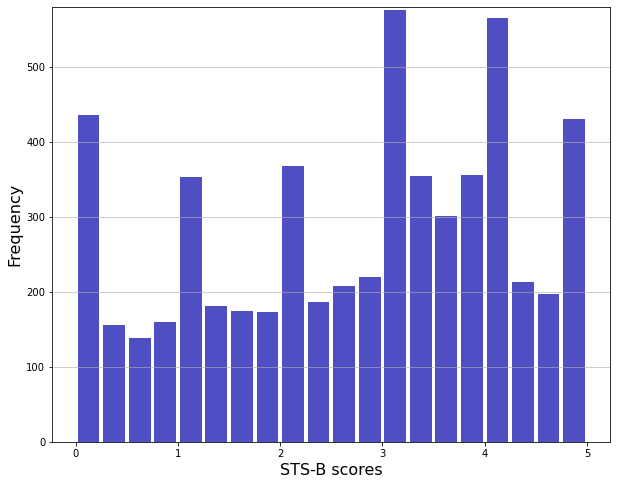

In [20]:
### Histogram for STS-B

plt.figure(figsize = (10, 8))
n, bins, patches = plt.hist(x=stsb_train.score, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('STS-B scores', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
# plt.title('Distribution of STS-B scores', fontsize = 18)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

plt.savefig('stsb-hist.png')

In [26]:
# print number of examples for development sets
dev_list = [wnli_dev, rte_dev, mrpc_dev, cola_dev, stsb_dev, sst2_dev, qqp_dev, qnli_dev, mnli_dev_m, mnli_dev_mism]
dev_names = ['WNLI', 'RTE', 'MRPC', 'STS-B', 'CoLA', 'SST-2', 'QQP', 'QNLI', 'MNLI_matched', 'MNLI_mismatched']

counter = 0
for dev in dev_list:
    print('{}'.format(dev_names[counter]))
    print('Number of sentences: {:,}'.format(dev.shape[0]))
    print('\n')
    counter += 1

WNLI
Number of sentences: 71


RTE
Number of sentences: 277


MRPC
Number of sentences: 408


STS-B
Number of sentences: 1,042


CoLA
Number of sentences: 1,500


SST-2
Number of sentences: 872


QQP
Number of sentences: 40,431


QNLI
Number of sentences: 5,732


MNLI_matched
Number of sentences: 9,815


MNLI_mismatched
Number of sentences: 9,832


